# Image Captioning
## Introduction
本范例通过使用卷积神经网络（CNN）和递归神经网络（RNN）构建一个图像描述生成器。

本范例使用Tensorflow和Keras实现。

所用的数据集为Flickr 8K，该数据集包含8,000张图像，每张图像配有五个不同的描述性文字说明。

本范例的模型架构由CNN和RNN组成，其中CNN用于提取图像特征并对输入图像进行编码，RNN则基于长短期记忆网络（LSTM）来生成描述文字。

与其他常见的模型相比，区别在于图像嵌入仅作为第一个输入提供给RNN网络且仅提供一次。


## Dependencies

In [ ]:
import re
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from time import time

from tqdm import tqdm # 进度条工具包，用于展示进度条
from sklearn.model_selection import train_test_split # 数据集的分割，将数据集分为训练集和测试集
from nltk.translate.bleu_score import corpus_bleu # 用于计算BLEU评分，该评分用来评估输出文本的转译质量

## Dataset
从本地路径或Google Drive上加载数据

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# 修改下述路径为你的本地路径
dataset_path = "/home/admin/Downloads/Resources"
dataset_images_path = dataset_path + "/Images/" 

- 图片配置

In [ ]:
img_height = 180
img_width = 180
validation_split = 0.2

### Encoder Model

为了从图像中提取特征，使用预训练的卷积神经网络（CNN）模型-Inception V3。下图展示了所使用网络的架构。

![Inception Architecture](https://paperswithcode.com/media/methods/inceptionv3onc--oview_vjAbOfw.png)

In [ ]:
# 移除Inception V3模型的最后一层

def get_encoder():
    # 加载预训练的Inception V3模型，并去掉顶层全连接层（include_top=False）
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    
    # 获取模型的输入层
    new_input = image_model.input
    
    # 获取模型的最后一层输出（去掉了顶层的全连接层）
    hidden_layer = image_model.layers[-1].output

    # 构建一个新的模型，以原始输入为输入，以隐藏层输出为输出
    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    
    return image_features_extract_model

### Read captions

In [ ]:
# Preprocess the caption, splitting the string and adding <start> and <end> tokens
def get_preprocessed_caption(caption):    
    # 预处理标签，去除不应有的空格，且使用<start>和<end>标签来展示开头和结尾
    caption = re.sub(r'\s+', ' ', caption)  # 将引号举的空白置换为单空格
    caption = caption.strip()  # 去除带有的头尾空格
    caption = "<start> " + caption + " <end>"
    return caption

In [ ]:
# 创建一个字典用于存储图像和它们对应的描述
images_captions_dict = {}

# 打开包含描述的文本文件
with open(dataset_path + "/captions.txt", "r") as dataset_info:
    next(dataset_info) # 跳过标题行：图像, 描述

    # 只使用 40,000 个条目中的前 4,000 个条目
    for info_raw in list(dataset_info)[:4000]:
        # 将每行内容用逗号分隔，得到图像文件名和描述
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        # 如果图像文件名不在字典中，则创建一个新条目
        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        # 否则，将描述添加到已有条目中
        else:
            images_captions_dict[image_filename].append(caption)

### Read images


In [ ]:
def load_image(image_path):
    # 读取图片文件路径的数据。
    img = tf.io.read_file(dataset_images_path + image_path)
    # 将数据解码成JPEG图片，使用三个通道。
    img = tf.image.decode_jpeg(img, channels=3)
    # 调整图片的尺寸为指定的高度和宽度。
    img = tf.image.resize(img, (img_height, img_width))
    # 为预训练的InceptionV3模型进行图片预处理。
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
# 将图片的键列表转换为一个TensorFlow数据集
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)

# 对每个图片键，应用 `load_image` 函数进行图像的加载，并将加载的图像按批次大小为64进行分批
# 使用 `num_parallel_calls=tf.data.experimental.AUTOTUNE` 表示并行加载图像，以优化性能
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
# 创建一个空字典来存储图像特征
images_dict = {}

# 获取编码器（encoder），用于将图像编码为特征向量
encoder = get_encoder()

# 遍历图像数据集中的每个图像和其对应的路径
for img_tensor, path_tensor in tqdm(image_dataset):
    # 使用编码器将图像张量转换为特征向量
    batch_features_tensor = encoder(img_tensor)
    
    # 遍历每个特征向量和对应的路径，并将其存储到字典中
    for batch_features, path in zip(batch_features_tensor, path_tensor):
        # 将路径张量转换为字符串类型
        decoded_path = path.numpy().decode("utf-8")
        # 将特征向量存储到字典中，键为路径，值为特征向量
        images_dict[decoded_path] = batch_features.numpy()

13it [00:21,  1.64s/it]


从预训练模型中提取特征后的图像大小

In [ ]:
list(images_dict.items())[0][1].shape

(4, 4, 2048)

显示原始数据集中的图像

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


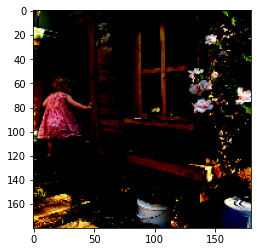

In [ ]:
plt.imshow(load_image('1000268201_693b08cb0e.jpg')[0].numpy())

### Get images and labels from filenames

In [ ]:
# 函数 get_images_labels 用于从图片文件名中获取图片和标签

def get_images_labels(image_filenames):
    images = []  # 用于存储所有的图片
    labels = []  # 用于存储所有的标签
    
    # 遍历每个图片名
    for image_filename in image_filenames:
        image = images_dict[image_filename]  # 从 images_dict 中获取图片
        captions = images_captions_dict[image_filename]  # 从 images_captions_dict 中获取该图片的标签

        # 为每个标签添加一个对应的图片实例
        for caption in captions:
            images.append(image)  # 将图片添加到 images 列表
            labels.append(caption)  # 将标签添加到 labels 列表
            
    return images, labels  # 返回所有的图片和标签

### Generate train and test set

这种方法划分 image_filenames，以避免训练和测试数据集中相同的图像具有不同的标题。

此外，生成的训练测试不会被打乱，因为将使用张量流本机方法来实现该目标。

In [ ]:
# 该段代码首先将图像文件名拆分为训练集和测试集，然后分别获取这些文件对应的图像和标签

# 获取字典中所有图片的文件名列表
image_filenames = list(images_captions_dict.keys())

# 将文件名列表按照比例拆分为训练集和测试集
# 参数 "test_size=validation_split" 表示将指定比例的文件名分配到测试集中，剩下的为训练集
# 参数 "random_state=1" 用于保证数据拆分的可重复性
image_filenames_train, image_filenames_test = \
    train_test_split(image_filenames, test_size=validation_split, random_state=1)

# 根据训练集的文件名，获取对应的图像和标签
X_train, y_train_raw = get_images_labels(image_filenames_train)

# 根据测试集的文件名，获取对应的图像和标签
X_test, y_test_raw = get_images_labels(image_filenames_test)

In [ ]:
# Per image 5 captions and 0.2 test split
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

### Tokenize train labels


生成词汇表并将训练标题转换为向量及其在词汇表中的索引 

In [ ]:
# 设置要提取的最大词汇量为 5000 个单词
# 从 7600 个单词中选出最常用的 5000 个
# 初始化一个分词器，并设置最大单词数量为 top_k，
# 同时使用 "<unk>"（未知词）来表示未在词汇表中的词语
# 过滤掉字符串中特定的符号

# 设置top_k为5000，即提取最常见的5000个词汇
# 使用 TensorFlow 的分词工具 Tokenizer
# 将句子中某些字符进行过滤，且未收录词汇会用 "<unk>" 表示
top_k = 5000  # 选择从7600个词汇中取出最多5000个单词
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~ ')

# 从训练集的原始描述（y_train_raw）中生成词汇表
# fit_on_texts方法会基于提供的文本进行词汇统计并生成相应的词汇表
tokenizer.fit_on_texts(y_train_raw)

# 为了方便后续模型处理，将 '<pad>' 用于填充，使得所有描述的长度一致
# 这里将 '<pad>' 设定为索引 0，确保该填充值为固定标记
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# 将训练集描述（y_train_raw）转换为词汇索引的形式
# texts_to_sequences 会将每个句子中的词汇替换为对应词汇表中的索引
y_train = tokenizer.texts_to_sequences(y_train_raw)

# 将这些序列向量进行填充，以使所有描述具有相同的长度
# 这里使用后端填充方式 ('post')，即在序列末尾填充 0
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

计算最大标题长度，即 LSTM 中隐藏层的数量。

In [ ]:
# 计算 y_train 中最长的字符串的长度
max_caption_length = max(len(t) for t in y_train)

# 打印出最长字符串的长度
print(max_caption_length)


35


Example tokenization

In [ ]:
[tokenizer.index_word[i] for i in y_train[1]]

['<start>',
 'a',
 'black',
 'dog',
 'is',
 'standing',
 'on',
 'a',
 'step',
 'next',
 'to',
 'a',
 'river',
 'at',
 'it',
 'shakes',
 'itself',
 'dry',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Generate Tensorflow dataset

使用训练期间使用的缓冲区和批量大小生成数据集。

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [ ]:
# 设置缓冲区大小为训练数据的长度
BUFFER_SIZE = len(X_train)
# 设置每批次的大小
BATCH_SIZE = 64
# 计算训练过程中需要的批次数量
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE

# 随机打乱数据并按批次大小进行分组
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 使用预取技术来提高数据加载性能，详细信息参考：https://www.tensorflow.org/guide/data_performance#prefetching
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Models Definition

### CNN Encoder

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # 由于特征已经被提取并使用 pickle 保存，
    # 这个编码器会将这些特征传递给一个全连接层
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # 通过全连接层后的形状为 (batch_size, 64, embedding_dim)
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim) # 全连接层，embedding_dim 为输出维度

    def call(self, x):
        x = self.flat(x)  # 将输入展平
        x = self.fc(x)  # 通过全连接层
        return x

### RNN Decoder

In [ ]:
import tensorflow as tf

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # input_dim = 输入字典大小
        # 定义并实现将输入的标题序列转换为并列表示的层级
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # 定义长短期记录层(LSTM)，用来预测序列中的下一个字
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
            
        # 定义一个全连接层，用于将LSTM的输出转换为实际输出的词汇选择
        self.fc = tf.keras.layers.Dense(vocab_size) #, activation='softmax')

    # 转换输入并返回LSTM层的输出
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        # 将标题的序列转换为并列转换表示的表示形式
        embed = self.embedding(captions) #(batch_size, 1, embedding_dim)

        if verbose:
            print("Embed")
            print(embed.shape)

        # 将特征输入拉伸一个维度，方便与标题信息连接
        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        
        # 将图像特征与标题的并列转换表示连接起来，连接后的形式为 (batch_size, 1, embedding_dim + hidden_size)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
        
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)

        # 将连接后的向量输入LSTM层
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)

        # 将LSTM的输出单元转换为字典输出
        output = self.fc(output)

        return output, memory_state, carry_state

    # 重置状态的函数，初始化并返回全为0的状态值
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Train Stage

In [ ]:
# 设置嵌入维度和词汇大小
units = embedding_dim = 512 # 根据论文中的设置
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys())) # 设置词汇表的大小，最多为 top_k+1，取实际词汇量和 top_k+1 中的最小值

# 初始化编码器和解码器
encoder = CNN_Encoder(embedding_dim) # 使用指定的嵌入维度初始化卷积神经网络编码器
decoder = RNN_Decoder(embedding_dim, units, vocab_size) # 使用指定的嵌入维度、单元数和词汇大小初始化循环神经网络解码器

# 初始化优化器
optimizer = tf.keras.optimizers.Adam() # 使用 Adam 优化器

# 设置损失函数，使用 Sparse Categorical Crossentropy，因为标签不是独热编码，而是索引值
# logits 表示输入的预测值未经过 softmax，直接是神经网络输出的分数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 定义损失计算函数，使用 Sparse Categorical Crossentropy 计算损失，并在张量上计算单个损失的平均值
def loss_function(real, pred, verbose=False):
    loss_ = loss_object(real, pred) # 计算实际值和预测值之间的损失
    
    if verbose: # 如果设置为详细输出模式
        print("Loss")
        print(loss_) # 打印初步计算的损失值
    
    loss_ = tf.reduce_mean(loss_, axis=1) # 在第一个维度上对损失求平均值
        
    if verbose: # 如果设置为详细输出模式
        print("After Mean Axis 1")    
        print(loss_) # 打印求平均后的损失值

    return loss_ # 返回最终的损失值

In [ ]:
# 将 Python 代码转换为 tf.function 时，需要注意 Python 的副作用，例如打印、列表添加等，只会在函数被跟踪（traced）时执行一次。
# 如果想在 tf.function 内执行副作用，需要使用 TensorFlow 的操作来完成。

@tf.function
def train_step(img_tensor, target, verbose=False):    
    # 如果 verbose 参数为 True，则打印图像张量的形状和目标的形状
    if verbose:
        print("Image tensor")
        print(img_tensor.shape)

        print("Target")
        print(target.shape)    

    # 将目标张量的每一行去掉最后一个元素，作为解码器的输入，以便为第一个词的生成留出空间（图像嵌入）
    dec_input = tf.convert_to_tensor(target[:, :-1])

    # 使用 GradientTape 记录梯度计算过程
    # 参考：https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        # 使用编码器对图像张量进行特征提取
        features = encoder(img_tensor)
        
        # 如果 verbose 参数为 True，则打印特征提取的结果
        if verbose:
            print("Features CNN")
            print(features)
        
        # 使用解码器对输入进行预测，返回预测结果
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)        
        
        # 如果 verbose 参数为 True，则打印 RNN 的预测结果
        if verbose:
            print("Predictions RNN")
            print(predictions)
        
        # 计算目标和预测结果之间的损失
        caption_loss = loss_function(target, predictions) # (batch_size, )

        # 计算整个 batch 的总损失和平均损失
        total_batch_loss = tf.reduce_sum(caption_loss) # 求和 (batch_size, ) => 标量
        mean_batch_loss = tf.reduce_mean(caption_loss) # 求均值 (batch_size, ) => 标量

    # 更新可训练变量
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(caption_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

### Checkpoint

在本地路径上创建张量流检查点，以在训练时保存编码器和解码器状态。仅保存最后 5 个模型。

In [ ]:
# 设定模型的保存路径
checkpoint_path = "./checkpoints/train"

# 创建一个检查点实例对象，用于保存编码器（encoder），解码器（decoder），和优化器（optimizer）的状态
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

# 创建一个检查点管理器（CheckpointManager），用于管理和保存最多 5 个检查点
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
# 设置初始的训练轮数为 0
start_epoch = 0

# 如果最新的检查点存在，则访问最新检查点并将轮数设置为检查点的轮数
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # 恢复保存的最新检查点
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Start Training

In [ ]:
loss_plot = []

In [ ]:
# 设置训练的总轮次为5轮
EPOCHS = 5
# 起始轮次从第0轮开始
start_epoch = 0

# 循环执行每一轮训练
for epoch in range(start_epoch, EPOCHS):
    # 计算当前实际的训练轮次，等于已存储的损失记录长度加1
    real_epoch = len(loss_plot) + 1
    # 记录当前轮次的开始时间
    start = time()
    # 初始化总损失为0
    total_loss = 0

    # 遍历数据集的每个批次进行训练
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # 对当前批次进行训练，返回批次总损失和平均损失
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
        # 累加每个批次的总损失
        total_loss += total_batch_loss

        # 每100个批次打印一次当前的损失信息
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))
    
    # 打印当前轮次的总损失
    print ('Total Loss {:.6f}'.format(total_loss))
    # 计算并存储当前轮次的平均损失
    epoch_loss = total_loss / NUM_STEPS
    
    # 将当前轮次的损失值添加到损失列表中，以便后续绘制损失变化曲线
    loss_plot.append(epoch_loss)

    # 每5个轮次保存一次检查点
    if epoch % 5 == 0:
        ckpt_manager.save()

    # 打印当前轮次的平均损失
    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    # 打印当前轮次的训练耗时
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Epoch 71 Batch 0 Batch Loss 0.2486
Total Loss 28630.128906
Epoch 71 Epoch Loss 572.602600
Time taken for 1 epoch 34.57038116455078 sec

Epoch 72 Batch 0 Batch Loss 0.2462
Total Loss 28464.093750
Epoch 72 Epoch Loss 569.281860
Time taken for 1 epoch 35.65265774726868 sec

Epoch 73 Batch 0 Batch Loss 0.2370
Total Loss 28397.576172
Epoch 73 Epoch Loss 567.951538
Time taken for 1 epoch 35.114084243774414 sec

Epoch 74 Batch 0 Batch Loss 0.2481
Total Loss 28211.250000
Epoch 74 Epoch Loss 564.224976
Time taken for 1 epoch 38.29546332359314 sec

Epoch 75 Batch 0 Batch Loss 0.2421
Total Loss 28106.376953
Epoch 75 Epoch Loss 562.127563
Time taken for 1 epoch 41.556641578674316 sec



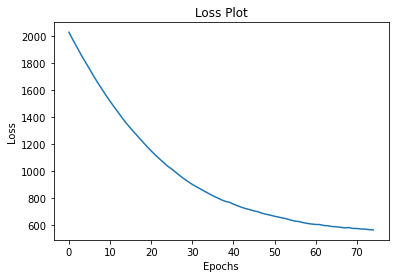

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Test Stage

### Evaluate random image

In [ ]:
# 定义函数 `clean_caption`，用于清理生成的序列中的特殊标记
# 这些特殊标记包括 '<start>', '<end>', '<pad>'
def clean_caption(caption):
    # 使用列表推导式过滤掉这些特殊标记，保留其他有效内容
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

# 这个函数的目的是从生成的文本序列中去除开始、结束和填充标记，
# 保证输出的序列只包含有意义的部分，适用于自然语言生成任务。

In [ ]:
test_img_name = random.choice(image_filenames_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real captions
<start> A brown dog is running after a black dog on a rocky shore . <end>
<start> A brown dog is running after the black dog . <end>
<start> Two dogs playing on a beach . <end>
<start> Two dogs run across stones near a body of water . <end>
<start> Two dogs run towards each other on a rocky area with water in the background . <end>
Esimated caption
['a', 'dog', 'is', 'running', 'in', 'a', 'field']


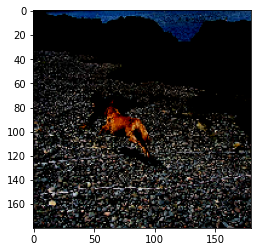

In [ ]:
# 从测试图像中获取caption

def get_caption(img):    
    # 将图像添加到数组中，以模拟批大小为1    
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    # 将图像嵌入输入到训练好的LSTM层中，预测序列的第一个单词。
    # 输出、隐藏状态和记忆状态再次传递给LSTM，以生成下一个单词。
    # 该迭代会重复进行，直到caption达到最大长度。
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        # 获取预测的最大索引
        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # 过滤caption中的特殊标记
    return clean_caption(caption)

raw_img = load_image(test_img_name)[0]
img = images_dict[test_img_name]
captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

print("真实caption")
for caption in captions:
    print(caption)

print("预测的caption")
estimated_caption = get_caption(img)
print(estimated_caption)

### Evaluate dataset using BLEU

In [ ]:
def get_caption(img):    
    # 将图像添加到数组中，模拟批处理大小为1
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    state = None
    for i in range(1, max_caption_length):
        # 通过解码器生成预测、记忆状态和携带状态
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        # 获取预测结果中概率最大单词的索引
        word_index = np.argmax(predictions.numpy().flatten())

        # 将预测的单词添加到字幕列表中
        caption.append(tokenizer.index_word[word_index])

        # 更新解码器的输入
        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # 过滤生成的caption
    return clean_caption(caption)

# 初始化存储实际值和预测值的列表
actual, predicted = [], []

# 遍历测试图像名称，获取每个图像的估计caption
for test_img_name in image_filenames_test:
    img = images_dict[test_img_name]
    estimated_caption = get_caption(img)

    # 清洗并获取图像的真实caption列表
    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]]
    
    # 存储实际caption和预测caption
    actual.append(captions)
    predicted.append(estimated_caption)

# 打印 BLEU 分数
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.381865
BLEU-2: 0.206159
